# Level 1 vs Level 2 Landsat Satellite Data:

## A comparison using Modified Normalised Difference Water Index (MNDWI)

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene), [ls_usgs_wofs_scene](https://explorer.digitalearth.africa/ls_usgs_wofs_scene)
* **Level 1 data retrived from:**
[Landsat 8 Level 1 data](https://registry.opendata.aws/landsat-8/) (last accessed 10 July 2020)

## Background

### Analysis-Ready Data (ARD): the difference between Level 1 and Level 2 data

Satellite operators, such as the USGS, perform pre-processing on raw satellite data before releasing it for use. The amount of pre-processing differs between products. The USGS taxonomy for the these differing amounts of pre-processing is ordered by `Collections` and `Levels`.

`Collections` indicate the data meets a standardised set of metrics for quality and type of pre-processing. This is consistent within the collection, but varies between collections. For example, Collection 2 uses more advanced data processing than Collection 1. At time of writing, only Collection 1 is available for general use.

`Levels` indicate the amount of pre-processing. Higher-level data has undergone more pre-processing.

The data we examine in this notebook is from the `USGS Collection 1` archive for the satellite `Landsat 8`. We look at both `Level 1` and `Level 2` data.

* **Collection 1, Level 1 data** : Level 1 data is very close to its raw format, it can be flexibly manipulated by the scientific community, but requires specialist knowledge to use. Atmospheric interference and other underlying satellite data issues are not corrected for.

* **Collection 1, Level 2 data**: The accessibility of available satellite data can be significantly increased by further processing the Level 1 data, such as by applying atmospheric corrections. Level 2 data is hosted on DE Africa's `OpenDataCube`, and is known as `Analysis-Ready Data (ARD)`. The corrections improve the overall quality of the data (compared to the Level 1 data) and allow users to conduct analysis independent of expertise in the data corrections process. The terms `ARD` and `Level 2 data` will be used interchangeably in this notebook.

### Modified Normalised Difference Water Index (MNDWI)

MNDWI is a variation on the Normalised Difference Water Index (NDWI). NDWI is used to detect the presence of water bodies in remote sensing, and is calculated using the Green band and Near-Infrared (NIR) bands from satellite data.

\begin{equation} \text{NDWI} \ = \ \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}} \end{equation}

However, it has been shown that using a Short-Range Infrared (SWIR) band instead of NIR provides enhanced delineation between water and other types of areas (soil, vegetation, built-up land). This gives the Modified NDWI, or MNDWI.

\begin{equation} \text{MNDWI} \ = \ \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}} \end{equation}

In the case of Landsat 8 satellite data, which has two SWIR bands, SWIR 1 is used. The indices are normalised, which means their values range from -1 to 1. Generally, this can be interpreted as:

* MNDWI $> 0$ : water
* MNDWI $\leq 0$ : soil, vegetation, urban areas

## Description

This notebook will show how ARD (Level 2) data differs from the less pre-processed Level 1 data. This is done by calculating MNDWI using Level 1 data and Level 2 data from Landsat 8, for the same region. Differences in the MDNWI between the datasets demonstrate the enhanced usability of ARD over Level 1 data.

The notebook contains the following steps:
1. Fulfill prerequisites: select a location for analysis and download Level 1 data.
2. Load Level 1 data for the location.
3. Load Level 2 data for the location.
4. Calculate MNDWI for the Level 1 data.
5. Calculate MNDWI for the Level 2 data.
6. Compare the Level 1 and Level 2 data by plotting them together. The analysis includes:
    * A close-up, small region comparison of MNDWI
    * Thresholding MNDWI at 0 to show noise in Level 1 data
    * Calculation of a suitable threshold for the Level 1 dataset
    * Using optimised thresholds for MNDWI to calculate and compare waterlines
    * Comparison of MNDWI at different timesteps to show successful cloud reduction in Level 2 data
7. Conclusions and acknowledgements

*****

## Getting Started
To run this analysis, ensure the prerequesites are fulfilled, then run all the cells in the notebook, starting with the "Load packages" cell. 

### Prerequisites

The Digital Earth Africa (DE Africa) sandbox does not index Landsat 8 Level 1 data. This means Level 1 data must be manually downloaded from the USGS website before it can be imported into the notebook. A time and place for analysis must be decided.

* Choosing location

For the purposes of this notebook, a mix of water and land areas is desireable. An area off the coast of Guinea-Bissau has been selected. This is centred around the following coordinates:

`lat = 11.228`<br>
`lon = -15.860`

* Choosing time

Here, MNDWI is calculated for a single instance in time. The period of time chosen for this notebook was `January 2018`. Fortuitously, there is only one "scene" (satellite flyover) for the chosen location during the month of January 2018. If there were multiple flyovers, only one would have been selected.

* Downloading Level 1 data

*Note: this requires an active Amazon Web Services (AWS) account.*

The time and place can now be searched on the [DE Africa Metadata Explorer](https://explorer.digitalearth.africa/ls8_usgs_sr_scene). If not preselected, the selected product should be `ls8_usgs_sr_scene`. Use the `Year` and `Month` dropdowns to select `2018` and `January` as appropriate.

By browsing the `Day` dropdown, the only scene encapsulating the Bissau coast is `9 January 2018`. Click `11 datasets available` on the right-hand toolbar to open details of each scene taken on that day. The datasets are separated by location; the Bissau coast is the last dataset: [13b9c5f0-65f0-5d2e-8473-5bbfc92a9673](https://explorer.digitalearth.africa/dataset/13b9c5f0-65f0-5d2e-8473-5bbfc92a9673). Note this code; it is the `Scene ID` and will be needed later for datacube imports. Note the `Locations > Active:` field as it shows the naming convention for this scene.

Navigate to the [USGS Landsat 8 registry](https://registry.opendata.aws/landsat-8/) and access their AWS S3 Bucket. The file naming convention is the same as the `Locations > Active` field in the DE Africa Explorer; i.e. look for a folder starting with `LC08_L1TP_204052_20180109_20180119_01_T1`. 

The folder for this scene will contain many files. Download the Band 3 `_B3` and Band 6 `_B6` `.tiff` files locally and upload them to the same Jupyterlab folder as this notebook. This can be done by clicking the `Upload files` button on the horizontal toolbar options in the sandbox File Browser.


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
from datacube.testutils import io
from datacube.utils import masking
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import xarray as xr
import numpy as np
import seaborn as sns
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices
from deafrica_plotting import rgb
from deafrica_plotting import display_map
from deafrica_spatialtools import subpixel_contours
from deafrica_datahandling import wofs_fuser, mostcommon_crs

/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Viewer requires Qt
  app.launch_new_instance()


### Connect to the datacube
Connect to the datacube so we can access DE Africa data. The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="L1_L2_MNDWI_Comparison")

## Load required datasets

### Load Level 1 data - from file
The file suffix `B3` indicates Band 3, the Landsat 8 Green band. Likewise, `B6` is Band 6, the Landsat 8 SWIR 1 band. The `.tiff` files uploaded to the sandbox can be imported as `xarray.DataArray()`, and then combined into an `xarray.Dataset()`.

In [3]:
l1_green = io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B3.tiff')
l1_swir1 =  io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B6.tiff')

In [4]:
# Create a Dataset named 'l1_data' and add to it the DataArrays 'green' and 'swir1'.
l1_data = l1_green.to_dataset(name = 'green')
l1_data['swir1'] = l1_swir1

# Make no-data value NaNs
l1_data = l1_data.where(l1_data!=0)

print(l1_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


### Load Level 2 data - from datacube

To match the Level 1 data, we want to import the same scene from the Level 2 data hosted in the datacube. This can be done by specifying the exact scene using the `Scene ID` field from the DE Africa Metadata Explorer. See the *Prerequisites* section above. This fills the `'id'` field in the query.

The datacube contains measurements from all eleven bands of Landsat 8. We do not need them all! Calculating MNDWI requires only the Green band and SWIR 1 band, while true-colour plots used later require the Green, Red and Blue bands. We can specify the query to load these four bands only, by listing them under `'measurements'`. 

In [5]:
# Create query
query = {
    'product':'ls8_usgs_sr_scene',
    'id':'13b9c5f0-65f0-5d2e-8473-5bbfc92a9673',
    'measurements': ['green','swir1', 'red', 'blue'],
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':l1_data.geobox.crs
}

# Load dataset
l2_data = dc.load(**query).squeeze()

# Make no-data values NaNs
l2_data = l2_data.where(l2_data!=-9999)

print(l2_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
    time         datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


## Calculate MNDWI

MNDWI can be calculated using the pre-loaded `calculate_indices` function. It can alternatively be defined by the user - an example is shown below. In either case, `MNDWI` is added as a `Data variable` to the `DataSet` it is calculated for.

### Example: define your own MNDWI calculation
Future calls for `calculate_indices()` can be replaced with `calculate_mndwi(lx_data)`, where `x = 1` or `2`, corresponding to the names of the Level 1 and Level 2 datasets.

In [6]:
def calculate_mndwi(ds):
    ds['MNDWI'] = (ds.green - ds.swir1)/(ds.green + ds.swir1)
    return(ds)

The cells below use the standard DE Africa `calculate_indices` function, which require a few extra parameters. `index` defines the index to be calculated (in our case, MNDWI) and `c1` refers to Collection 1 of the DE Africa datacube products. 

### Level 1 MNDWI

In [7]:
l1_data = calculate_indices(l1_data, index = 'MNDWI', collection = 'c1') 

print(l1_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MNDWI        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


### Level 2 MNDWI

In [8]:
l2_data = calculate_indices(l2_data, index = 'MNDWI', collection = 'c1')

print(l2_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
    time         datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MNDWI        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


## Plot MNDWI

### Whole-scene plots

Subplots can be used to show the Level 1 and Level 2 MNDWIs side by side. Note the entire scene is fairly large (more than 7000 x 7000 pixels!) so the `figsize` dimensions cannot be too small or the data will not show.

*Note: this plot can cause the kernel to crash. If so, select* `Kernel > Restart Kernel and Run All Cells...` *to obtain the plot. The plot code can then be commented out using # to prevent overloading memory.*

In [9]:
# fig1, ax = plt.subplots(1, 2, figsize=(28,13))
# fig1.suptitle("MNDWI Comparison: Level 1 and Level 2 Data", size = 25)

# l1_data.MNDWI.plot(ax=ax[0], cmap='RdBu', vmin=-1, vmax=1)
# ax[0].set_title('Level 1 MNDWI', size = 20)

# l2_data.MNDWI.plot(ax=ax[1], cmap='RdBu', vmin=-1, vmax=1)
# ax[1].set_title('Level 2 MNDWI', size = 20);

### Waterline close-ups

The improvements provided by Level 2 data can be best exemplified by looking closer at a region where water meets land. We will look at the estuaries of the river Rio Baboque at two different scales.

In [10]:
# Rio Baboque x and y coordinates, in metres
zoomed_xmin = 388000
zoomed_xmax = 403000
zoomed_ymin = 1323000
zoomed_ymax = 1338000

# Note in the Dataset structure, y values are listed in decreasing order
# This means ymax is listed first when performing a slice() command in the y dimension

Text(0.5, 1.0, 'Level 2 MNDWI')

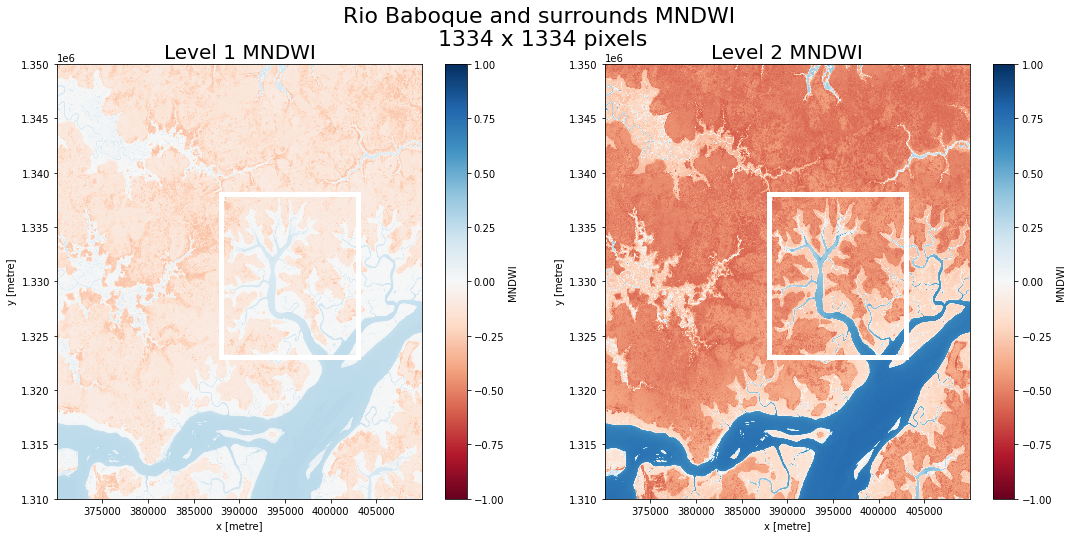

In [11]:
fig2, ax = plt.subplots(1, 2, figsize=(18, 8))
fig2.suptitle("Rio Baboque and surrounds MNDWI \n1334 x 1334 pixels", size=22)

l1_data.MNDWI.sel(x=slice(370000, 410000), y=slice(1350000, 1310000)).plot(
    ax=ax[0], cmap="RdBu", vmin=-1, vmax=1
)
selection = patches.Rectangle(
    (zoomed_xmin, zoomed_ymin),
    15000,
    15000,
    linewidth=5,
    edgecolor="w",
    facecolor="none",
)
ax[0].add_patch(selection)
ax[0].set_title("Level 1 MNDWI", size=20)

l2_data.MNDWI.sel(x=slice(370000, 410000), y=slice(1350000, 1310000)).plot(
    ax=ax[1], cmap="RdBu", vmin=-1, vmax=1
)
selection = patches.Rectangle(
    (zoomed_xmin, zoomed_ymin),
    15000,
    15000,
    linewidth=5,
    edgecolor="w",
    facecolor="none",
)
ax[1].add_patch(selection)
ax[1].set_title("Level 2 MNDWI", size=20)

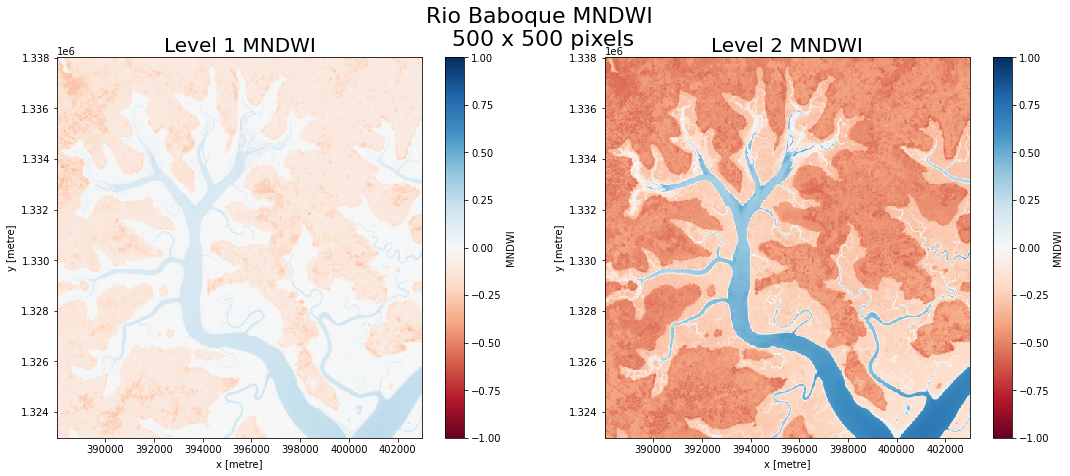

In [58]:
fig3, ax = plt.subplots(1, 2, figsize=(18, 7))
fig3.suptitle("Rio Baboque MNDWI \n500 x 500 pixels", size = 22)

l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[0], cmap='RdBu', vmin=-1, vmax=1)
ax[0].set_title('Level 1 MNDWI', size = 20)

l2_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[1], cmap='RdBu', vmin=-1, vmax=1)
ax[1].set_title('Level 2 MNDWI', size = 20);

## Analysis

### MNDWI distribution profiles

The MNDWI values can be plotted by frequency for the Rio Baboque area. This can be used to show how MNDWI ranges over this geographical region.

/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':


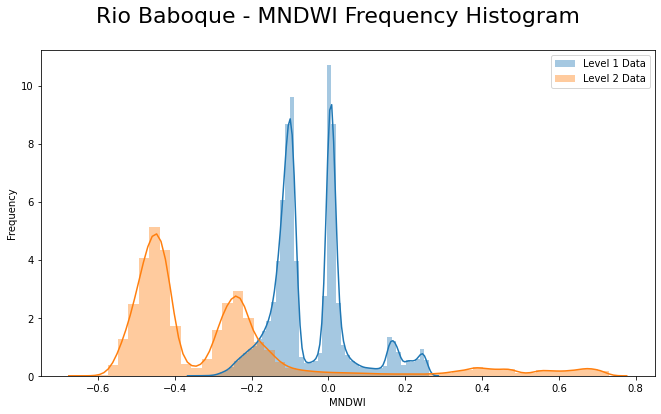

In [13]:
histl1 = l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).values.ravel()
histl2 = l2_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).values.ravel()

fig4, ax = plt.subplots(1, figsize=(11, 6))
fig4.suptitle("Rio Baboque - MNDWI Frequency Histogram", size = 22)

h1 = sns.distplot(histl1)
h2 = sns.distplot(histl2)

ax.set_xlabel('MNDWI')
ax.set_ylabel('Frequency')
ax.legend([h1, h2], labels = ['Level 1 Data', 'Level 2 Data'], loc = 'upper right')

The conventional threshold for MNDWI is 0; that is:
* MNDWI $> 0$ : water
* MNDWI $\leq 0$ : soil, vegetation, urban areas

As per the histogram, the Level 2 data shows a much clearer distinction between water and non-water areas. Both datasets show the same core features; two significant peaks on the negative end of the index, and two flatter peaks on the positive end. In the case of the Level 1 data, all four peaks are clustered around 0, with one peak almost centred on 0. Most data points fall between -0.3 to 3. This means it is difficult to distinguish predictions of water and land as the index values are very similar.

In contrast, the Level 2 data has its two major negative-MNDWI peaks centred around -0.25 and -0.45. This clearly denotes those areas as not-water; there is no peak around 0. The positive-MNDWI peaks are less distinct than in the Level 1 data, and this spread over the range shows nuance in regions of water. For example, at the end of estuaries as the channels become narrower there is a gradual decrease in MNDWI. This is not nearly as visible in the Level 1 data.

### Distinguishing water from land

The difference in distinction between water and not-water regions can be demonstrated by thresholding both datasets at MDNWI > 0. In the MNDWI plots below (left and middle),  datapoints greater than 0 ostensibly indicate water bodies and are shown in yellow. This can be compared to the true-colour plot (right), where the waterline is clearly visible.

The Level 2 data shows a water body profile very similar to the true-colour plot. The major river body is shown in both plots, and branching streams and creeks are distinct.

However, the Level 1 data struggles to distinguish between the smaller distributaries and land. This results in noisier edges, which corroborate with the cluster of datapoints around 0 as shown in the histogram.

In [14]:
water1 = l1_data.MNDWI.sel(x=slice(zoomed_xmin, zoomed_xmax), y=slice(zoomed_ymax, zoomed_ymin)) > 0
water2 = l2_data.MNDWI.sel(x=slice(zoomed_xmin, zoomed_xmax), y=slice(zoomed_ymax, zoomed_ymin)) > 0

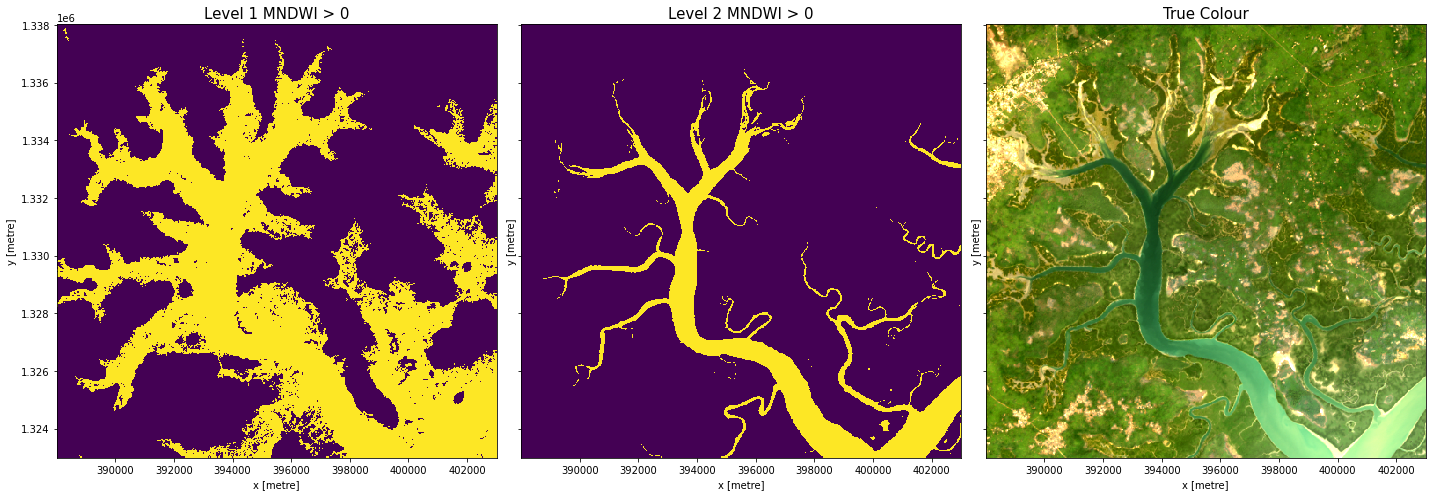

In [15]:
fig5, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(20, 7))

water1.plot(ax=ax[0], add_colorbar=False)
ax[0].set_title('Level 1 MNDWI > 0', size = 15)

water2.plot(ax=ax[1], add_colorbar=False)
ax[1].set_title('Level 2 MNDWI > 0', size = 15)

rgb(l2_data.sel(x=slice(zoomed_xmin, zoomed_xmax),
                y=slice(zoomed_ymax, zoomed_ymin)), ax=ax[2])
ax[2].set_title('True Colour', size = 15)

plt.tight_layout()

### Thresholding Level 1 data 

The above plots show the Level 1 data for this particular time and place do not agree with the statement *MNDWI > 0 is water*. We can find a different threshold that better suits the Level 1 data.

Thresholding is a method of image analysis that categorises pixels to select areas of interest and ignore others. The grouping is determined by a threshold. It has already been determined that 0 cannot be assumed as the most appropriate threshold value for the Level 1 data. Accurate contour extraction, which can be used to determine the waterline of water bodies, relies on a suitable threshold. 

There are many ways of determining a threshold; most use variations of statistical averages to choose the threshold value. The one below is calculated using *Yen's method*.  

In [18]:
# The Rio Baboque datasets were previously converted into DataArrays for the histogram
# Those arrays are a suitable format to be read by the skimage package

l1_threshold = skimage.filters.threshold_yen(histl1)
print("The Rio Baboque 9 Jan 2018 Level 1 threshold is {:.4f}.".format(l1_threshold))

The Rio Baboque 9 Jan 2018 Level 1 threshold is 0.0317.


In [19]:
# This cell can be uncommented and run to see the effects of different types of thresholding methods on the dataset

#fig, ax = skimage.filters.try_all_threshold(l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).values, figsize=(10, 8), verbose=False)
#plt.show()

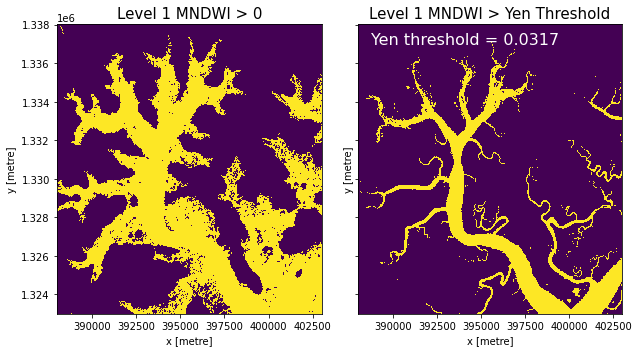

In [20]:
# We now set the threshold to the newly calculated one
l1_thresholded = l1_data.MNDWI.sel(x=slice(zoomed_xmin, zoomed_xmax), y=slice(zoomed_ymax, zoomed_ymin)) > l1_threshold

fig7, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(9, 5))
plt.locator_params(axis='x', nbins=6)

water1.plot(ax=ax[0], add_colorbar=False)
ax[0].set_title('Level 1 MNDWI > 0', size = 15)

l1_thresholded.plot(ax=ax[1], add_colorbar=False)
ax[1].set_title('Level 1 MNDWI > Yen Threshold', size = 15)
ax[1].annotate('Yen threshold = {:.4f}'.format(l1_threshold), fontsize = 16, xy = (0.05, 0.93), xycoords = 'axes fraction', color = 'white')

plt.tight_layout()

Adjusting the threshold to suit the Level 1 data has removed a lot of superfluous data points around what we know (from the Level 2 and True Colour plots) to be the actual water body. Some noise still exists, but the shape of the river is far more distinct.

## Application: waterline extraction - Level 1 vs Level 2 vs WOfS

MNDWI can be used to show the waterline of water bodies. The following process is mirrored from the [Contour extraction](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Frequently_used_code/Contour_extraction.ipynb) notebook, which contains further details on the applications and nuances of contour extraction.

We want a contour between water and non-water regions, so the contour is plotted at the relevant threshold for each level of data. A smaller area has been used so the contours can be clearly seen. 

* Level 1 data: MNDWI threshold = 0.0317
* Level 2 data: MNDWI threshold = 0

The subpixel contours create a `GeoDataFrame`. The contours can be plotted alone, but in this case they are plotted with True Colour maps to help distinguish water areas.

We then compare the MNDWI demarcation of water with the equivalent **Water Observations from Space** (WOfS) results. WOfS is a datacube product used for identifying water, dry land, and cloud. The product called upon here is `ls_usgs_wofs_scene`; as it is a Landsat product it also has a scene from 9 January 2018, so it can be compared directly with the MNDWI datasets. However, the WOfS data has a different `Scene ID` as it is a separate product. The required WOfS Scene ID can be found using the Metadata Explorer.

In [84]:
contour_xmin = 393500
contour_xmax = 397500
contour_ymin = 1333000
contour_ymax = 1337000

# Different region coordinates
# contour_xmin = 398000
# contour_xmax = 402000
# contour_ymin = 1323500
# contour_ymax = 1327500

l1_contour = l1_data.MNDWI.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin))
l2_contour = l2_data.MNDWI.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin))

# Extract contours. Here min_vertices is used to smooth the contour and remove very minor features
l1_contours_gdf = subpixel_contours(da = l1_contour, z_values = l1_threshold, crs = l2_data.crs, min_vertices = 10)
l2_contours_gdf = subpixel_contours(da = l2_contour, z_values = 0, crs = l2_data.crs, min_vertices = 10)

# Load the WOfS data from the datacube, making sure to use the correct product and scene ID
wofs = dc.load(product = "ls_usgs_wofs_scene", group_by="solar_day",
                            fuse_func=wofs_fuser,    
                            id = 'b7415d0e-47d5-4130-824e-856214e115f1',
                            resolution = (-30,30),
                            align = (15,15),
                            output_crs = l1_data.geobox.crs).squeeze()

# Create a contour for the WOfS dataset
wofs_contour = wofs.water.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin))
wofs_contours_gdf = subpixel_contours(da = wofs_contour, z_values = 1, crs = wofs.crs, min_vertices = 10)

Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode


Water is denoted in the WOfS datasets as pixels with the value `128` (this is related to how bit values are assigned to various terrain features). The third plot below shows the WOfS data, where water pixels are in yellow and all other pixels in purple.

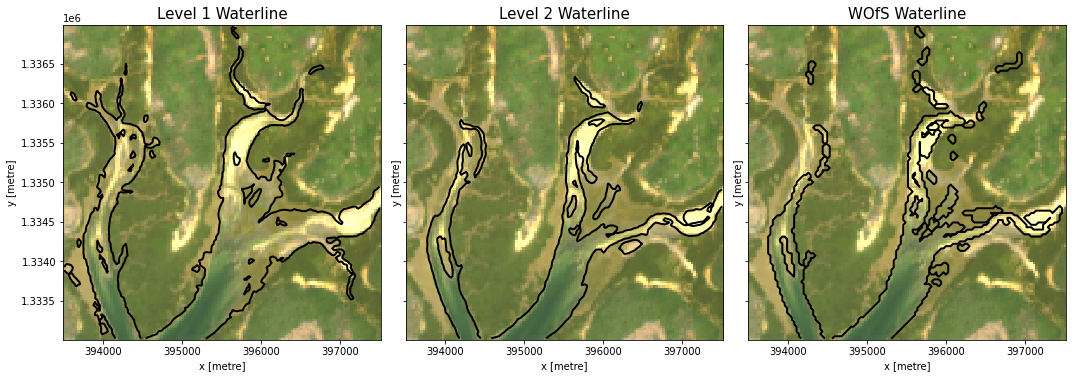

In [93]:
# Plot the data and contours

fig8, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
plt.locator_params(axis='x', nbins=5)

#l1_contour.plot(ax = ax[0], cmap = 'RdBu', vmin=-1, vmax=1, add_colorbar = False)
rgb(l2_data.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)), ax=ax[0], alpha = 0.8)
l1_contours_gdf.plot(ax = ax[0], linewidth=2, color='black')  
ax[0].set_title('Level 1 Waterline', size = 15)

#l2_contour.plot(ax = ax[1], cmap = 'RdBu', vmin=-1, vmax=1, add_colorbar = False)
rgb(l2_data.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)), ax=ax[1], alpha = 0.8)
l2_contours_gdf.plot(ax = ax[1], linewidth=2, color='black')  
ax[1].set_title('Level 2 Waterline', size = 15)

#(wofs.water == 128).sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)).plot(ax = ax[2], add_colorbar = False)
#l1_contours_gdf.plot(ax = ax[2], linewidth=1.5, color='black') 
#l2_contours_gdf.plot(ax = ax[2], linewidth=3, color='green')  
#ax[2].set_title('WOfS', size = 15)

rgb(l2_data.sel(x = slice(contour_xmin, contour_xmax), y = slice(contour_ymax, contour_ymin)), ax=ax[2], alpha = 0.8)
wofs_contours_gdf.plot(ax = ax[2], linewidth=2, color='black')  
ax[2].set_title('WOfS Waterline', size = 15)

plt.tight_layout()

We can also show the different contours on the same plot.

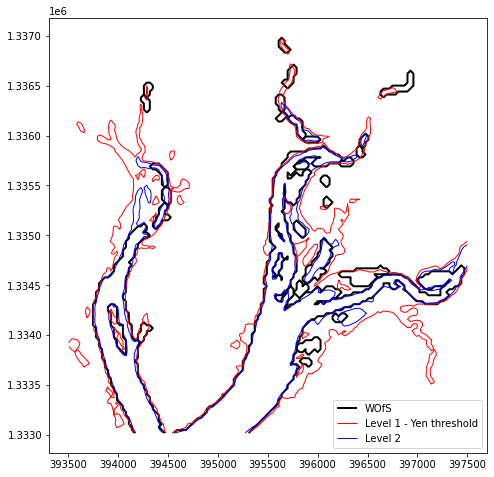

In [92]:
wofs_contours_gdf.plot(linewidth=2.0, color='black', figsize = (8, 8))  
l1_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='red')  
l2_contours_gdf.plot(ax = plt.gca(), linewidth=1.0, color='blue')  

plt.legend(labels = ['WOfS', 'Level 1 - Yen threshold', 'Level 2'], loc = 'lower right')

Both the separate contour plots and the stacked contour plots show each of the datasets have slightly different regions of water. 

The Level 1 data can be seen to overestimate the amount of water. The Yen threshold vastly improves the MNDWI range compared to using a threshold of 0, but the signal is still noisier than the datasets and likely includes areas which are not water. This can be determined by comparing to the WOfS and Level 2 contours, as well as the True Colour map.

The Level 2 and WOfS contours have more similar profiles. The Level 2 data appears to have the most conservative estimate of water.

### Temporal robustness

Another advantage of ARD is that removal of atmospheric interference decreases susceptibility to temporary fluctuations in readings caused by clouds or other vapours. To show this on the Guinea-Bissau coastal area, we will compare the MNDWI plots from the original scene (9 January 2018) to one from January 2019.

In [32]:
# Load all Level 1 and Level 2 data, as in the Prerequisites and initial steps
# Use the same region as before - a scene from Guinea-Bissau
# The prefix 'tr' is used to distinguish the variables for the new scene
# Note Level 1 data manual downloads can be skipped if the entire file path is known

# Level 1 - 12 January 2019
tr_l1_green = io.rio_slurp_xarray('s3://landsat-pds/c1/L8/204/052/LC08_L1TP_204052_20190112_20190131_01_T1/LC08_L1TP_204052_20190112_20190131_01_T1_B3.TIF')
tr_l1_swir1 =  io.rio_slurp_xarray('s3://landsat-pds/c1/L8/204/052/LC08_L1TP_204052_20180720_20180731_01_T1/LC08_L1TP_204052_20180720_20180731_01_T1_B6.TIF')
tr_l1_data = tr_l1_green.to_dataset(name = 'green')
tr_l1_data['swir1'] = tr_l1_swir1
tr_l1_data = tr_l1_data.where(tr_l1_data!=0)
tr_l1_data = calculate_indices(tr_l1_data, index = 'MNDWI', collection = 'c1') 

# Level 2 - 12 January 2019
tr_query = {
    'product':'ls8_usgs_sr_scene',
    'id':'9eeccf9d-bd4c-5300-8e88-a8c72a7a2ef1',
    'measurements': ['green','swir1', 'red', 'blue'],
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':tr_l1_data.geobox.crs
}
tr_l2_data = dc.load(**tr_query).squeeze()
tr_l2_data = tr_l2_data.where(tr_l2_data!=-9999)
tr_l2_data = calculate_indices(tr_l2_data, index = 'MNDWI', collection = 'c1')

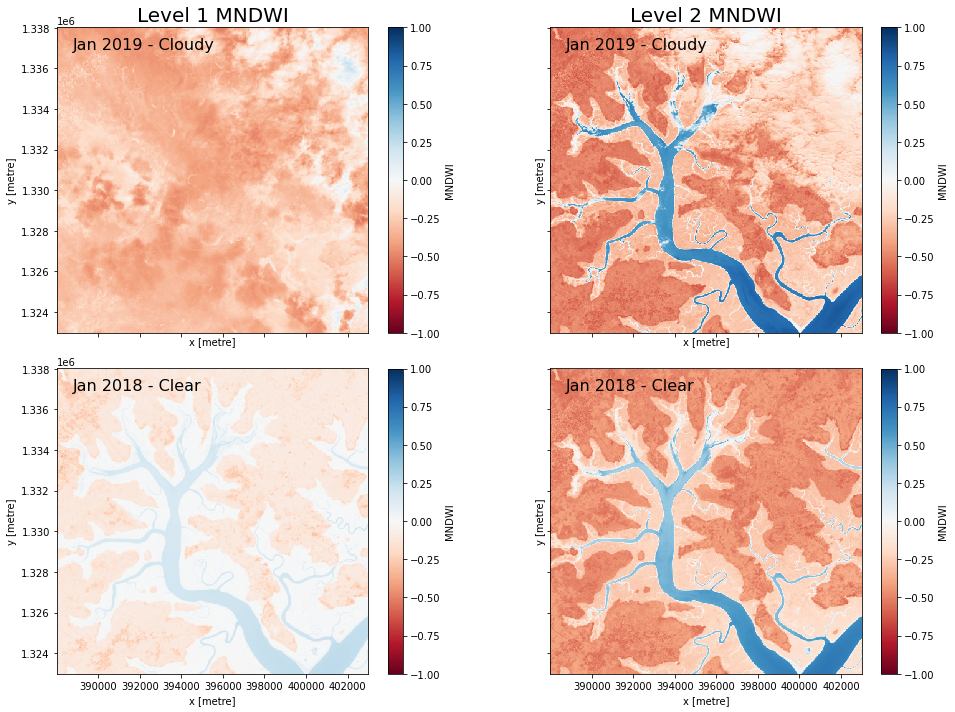

In [17]:
fig6, ax = plt.subplots(2, 2, figsize=(14, 10), sharey = True, sharex = True)

tr_l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[0, 0], cmap='RdBu', vmin=-1, vmax=1)
ax[0, 0].set_title('Level 1 MNDWI', size = 20)
ax[0, 0].annotate('Jan 2019 - Cloudy', fontsize = 16, xy = (0.05, 0.93), xycoords = 'axes fraction', color = 'black')

tr_l2_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[0, 1], cmap='RdBu', vmin=-1, vmax=1)
ax[0, 1].set_title('Level 2 MNDWI', size = 20)
ax[0, 1].annotate('Jan 2019 - Cloudy', fontsize = 16, xy = (0.05, 0.93), xycoords = 'axes fraction', color = 'black')

l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[1, 0], cmap='RdBu', vmin=-1, vmax=1)
ax[1, 0].set_title('', size = 4)
ax[1, 0].annotate('Jan 2018 - Clear', fontsize = 16, xy = (0.05, 0.93), xycoords = 'axes fraction', color = 'black')

l2_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[1, 1], cmap='RdBu', vmin=-1, vmax=1)
ax[1, 1].set_title('', size = 4)
ax[1, 1].annotate('Jan 2018 - Clear', fontsize = 16, xy = (0.05, 0.93), xycoords = 'axes fraction', color = 'black')

plt.subplots_adjust(left = 0.70)

plt.tight_layout()

The flyover from January 2019 was on a cloudy day, and this severely downgrades the quality of information in the Level 1 data. In contrast, the Level 2 data has been pre-processed to remove cloud interference, and shows values of MNDWI expected of the Rio Baboque area. Although the cloud masking is not perfect, the main river body is distinct, and the streams branching off from it are visible. This is a significant improvement over the Level 1 data.

An annual median, or other forms of statistical averages, are conventionally used to reduce the impact of variable atmospheric conditions. However, this does not diminish the superior data quality provided by the Level 2 data for a given increment of time.

## Conclusions

### Level 2 data is more suitable for calculating indices such as MNDWI

MNDWI is conventionally thresholded around 0; this is a suitable assumption for data that has been processed for surface reflectance, such as the Level 2 dataset. However, the Level 1 data, which does not contain atmospheric corrections, generally requires a custom-calculated threshold to optimise MNDWI. Calculating suitable thresholds is at minimum one extra step, and due to the variation in Level 1 data, could require recalculation for different scenes.

Once the data is refined, it is possible to use it for a myriad of applications, such as visualising waterlines.

### Level 2 data improves effective temporal resolution

Satellite observations are significantly impacted by variation in the Earth's atmosphere. The presence of clouds can distort or muffle measurements. This can be seen in the Level 1 data, where it is necessary to have a clear, cloud-free day to obtain useful readings. However, Level 2 data has been pre-processed to remove some of this noise, and is less dependent on favourable weather conditions. This effectively increases the temporal resolution of the dataset, as scenes do not have to be discarded due to cloud cover.

### Level 2 data is more user-friendly

Throughout this notebook, there have been extra steps taken to manipulate the Level 1 data so it could be visualised.

* Downloading it from the AWS S3 bucket
* Importing bands separately
* Combining bands into a `DataSet`
* Standardising `no-data` entries to `NaN`

These steps preclude actual data analysis and can act as a barrier for new datacube users.

***

**Acknowledgements:** Thank you to Chad for peer-review and editing, and Caitlin, Dave, Alex and Kirill for assistance.

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible `datacube` version:** 

In [23]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02
